In [1]:
from functions import *
from step1_functions import *
import pandas as pd
from time_stitches import *
import warnings

warnings.filterwarnings('ignore')

In [2]:
def convert_to_seconds(time):
    minutes, seconds_ = map(float, time.split('.'))
    if (seconds_<100):
        seconds = seconds_
        ms = 0
    else:
        seconds = seconds_ // 10
        ms_ = seconds_ % 10
        ms = ms_/10
    total_seconds = minutes * 60 + seconds + ms
    return total_seconds

In [3]:
sub_10_manual = pd.read_csv('Sub_10_annotations.csv', sep=';', decimal=',')
sub_10_manual['Start_event'] = sub_10_manual['Start_event'].round(3).map("{:.3f}".format)
sub_10_manual['End_event'] = sub_10_manual['End_event'].round(3).map("{:.3f}".format)
#convert in s
sub_10_manual['Start_event_s'] = sub_10_manual['Start_event'].astype('str').apply(convert_to_seconds)
sub_10_manual['End_event_s'] = sub_10_manual['End_event'].astype('str').apply(convert_to_seconds)
sub_10_manual.head(5)

,Subject,Start_event,End_event,Tool,Event,Start_event_s,End_event_s
0,10,0.000,2.450,Both,Task preparation,0.0,165.0
1,10,2.560,2.580,TW,Tool raised,176.0,178.0
2,10,3.290,3.330,TW,Moving plate,209.0,213.0
3,10,3.350,3.400,NH,Pulling thread,215.0,220.0
4,10,3.400,3.420,Both,Tool raised,220.0,222.0


In [4]:
sub_10_manual_nh = sub_10_manual[(sub_10_manual['Tool']=='NH') | (sub_10_manual['Tool']=='Both')]
sub_10_manual_tw = sub_10_manual[(sub_10_manual['Tool']=='TW') | (sub_10_manual['Tool']=='Both')]
sub_10_manual_nh.head(5)

,Subject,Start_event,End_event,Tool,Event,Start_event_s,End_event_s
0,10,0.000,2.450,Both,Task preparation,0.0,165.0
3,10,3.350,3.400,NH,Pulling thread,215.0,220.0
4,10,3.400,3.420,Both,Tool raised,220.0,222.0
5,10,3.510,4.530,NH,Pulling thread,231.0,293.0
6,10,4.430,4.560,NH,Tool raised,283.0,296.0


In [3]:
def select_points_manually(df_manual, df_data, delta_video_tracking=0):
    start_adjusted = df_manual['Start_event_s'] + delta_video_tracking
    end_adjusted = df_manual['End_event_s'] + delta_video_tracking
    # Créer une liste des intervalles [Start_event_s, End_event_s] de df_manual
    intervals = list(zip(start_adjusted, end_adjusted))
    
    condition = "|".join([f"(`Time (Seconds)` > {debut} & `Time (Seconds)` < {fin})" for (debut, fin) in intervals])
    # Filtrage du DataFrame
    df_filtered = df_data.query(f"not ({condition})")
    return df_filtered

In [6]:
i = 6
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{10}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{10}_TW_reconstructed.csv')

selected_nh_manual = select_points_manually(sub_10_manual_nh, needle_holder_rec, delta_video_tracking=5.5)
selected_tw_manual = select_points_manually(sub_10_manual_tw, tweezers_rec, delta_video_tracking=5.5)

Attention, ici, on n'a pas considéré le fait qu'il y avait deux vidéos et donc un décallage en plus pour la deuxième

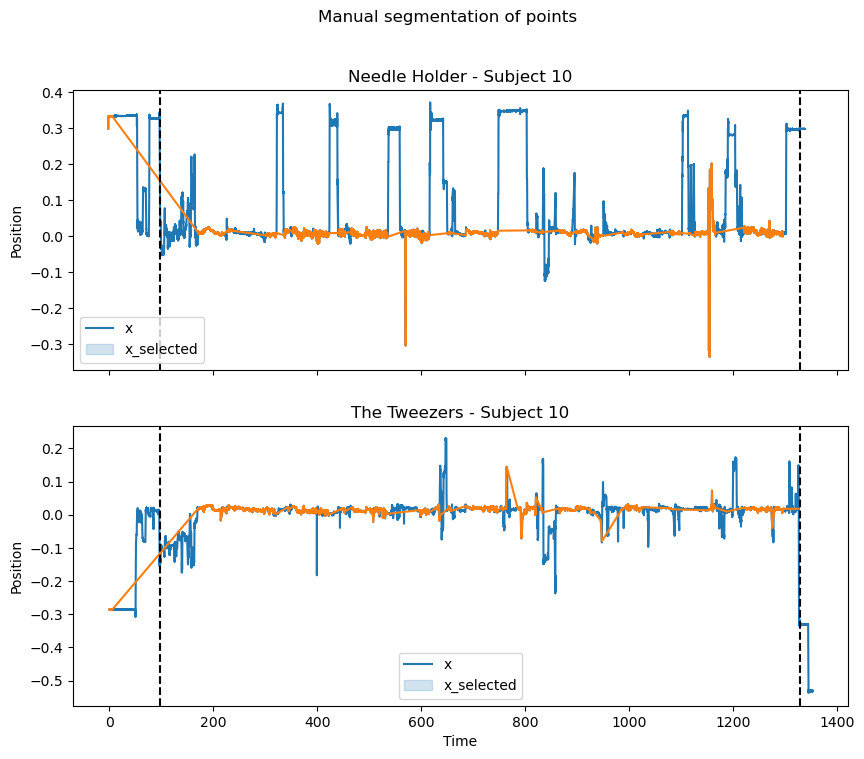

In [7]:
subject = 10

start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
sns.lineplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
#sns.scatterplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
#sns.scatterplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')

ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title(f'Needle Holder - Subject {subject}')
ax1.legend(['x', 'x_selected'])

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
sns.lineplot(x=selected_tw_manual['Time (Seconds)'], y=selected_tw_manual['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')

ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.legend(['x', 'x_selected'])
ax2.set_title(f'The Tweezers - Subject {subject}')
plt.suptitle('Manual segmentation of points')
plt.show()

## Tracking -  Video Adjustement

In [4]:
def adjust_time_on_nbr_videos(df):
    if (len(df['Video_nbr'].unique())>1):
        df['Start_event'] = df['Start_event'].astype(float)
        df['End_event'] = df['End_event'].astype(float)

        df.loc[df['Video_nbr'] == 2, ['Start_event', 'End_event']] += 16.02
        df.loc[df['Video_nbr'] == 3, ['Start_event', 'End_event']] += 32.04
        return df.round(3)
    else: return df

In [9]:
def select_points_manually(df_manual, df_data, delta_video_tracking=0):
    start_adjusted = df_manual['Start_event_s'] + delta_video_tracking
    end_adjusted = df_manual['End_event_s'] + delta_video_tracking
    # Créer une liste des intervalles [Start_event_s, End_event_s] de df_manual
    intervals = list(zip(start_adjusted, end_adjusted))
    
    condition = "|".join([f"(`Time (Seconds)` > {debut} & `Time (Seconds)` < {fin})" for (debut, fin) in intervals])
    # Filtrage du DataFrame
    df_filtered = df_data.query(f"not ({condition})")
    return df_filtered

In [5]:
sub_manual = pd.read_csv('Annotations_final.csv', sep=';', decimal=',')
#sub_manual['Start_event'] = sub_manual['Start_event'].round(3).map("{:.3f}".format)
#sub_manual['End_event'] = sub_manual['End_event'].round(3).map("{:.3f}".format)
sub_manual['Start_event'] = sub_manual['Start_event'].round(3)
sub_manual['End_event'] = sub_manual['End_event'].round(3)
sub_manual = adjust_time_on_nbr_videos(sub_manual) #adjust time when there were several videos

#convert in s
sub_manual['Start_event_s'] = sub_manual['Start_event'].astype('str').apply(convert_to_seconds)
sub_manual['End_event_s'] = sub_manual['End_event'].astype('str').apply(convert_to_seconds)

sub_manual_nh = sub_manual[(sub_manual['Tool']=='NH') | (sub_manual['Tool']=='Both')]
sub_manual_tw = sub_manual[(sub_manual['Tool']=='TW') | (sub_manual['Tool']=='Both')]


Looking at subj

In [ ]:
delta_video_tracking = {'20': [13, 14, 15],
                        '27' : [-1.5, 0, 0],
                        '13' : [-15.5, -14, -13],
                        '10' : [5, 7, 0],
                        '16' : [40, 0, 0],
                        '19': [-3.5, -2.5, 0]}

In [6]:
subject = 19
i=1
one_sub_nh = sub_manual_nh[sub_manual_nh['Subject']==subject]
one_sub_tw = sub_manual_tw[sub_manual_tw['Subject']==subject]
one_sub_nh.head(5)

,Subject,Start_event,End_event,Tool,Event,Video_nbr,Start_event_s,End_event_s
0,19,2.33,2.38,Both,Adjusting position,1,153.0,158.0
1,19,3.27,3.34,Both,Moving plate,1,207.0,214.0
2,19,3.51,4.01,Both,Moving plate,1,231.0,241.0
4,19,4.22,4.25,NH,Scrubbing,1,262.0,265.0
6,19,4.47,4.49,NH,Tool raised,1,287.0,289.0


In [7]:
def select_points_manually1(df_manual, df_data, delta_video_tracking=[0,0,0]):
    df_manual['Nbr_selection'] = 1 #video 1
    df_manual.loc[df_manual['Start_event_s'] > 962, ['Nbr_selection']] = 2 #video 2
    df_manual.loc[df_manual['Start_event_s'] > 1924, ['Nbr_selection']] = 3 #video 3

    nbr_video = len(df_manual['Nbr_selection'].unique())
    for i in range(nbr_video):
        df_manual.loc[df_manual['Nbr_selection'] == (i+1), ['Start_event_s', 'End_event_s']] += delta_video_tracking[i]
        

    #start_adjusted = df_manual['Start_event_s'] + delta_video_tracking
    #end_adjusted = df_manual['End_event_s'] + delta_video_tracking
    # Créer une liste des intervalles [Start_event_s, End_event_s] de df_manual
    intervals = list(zip(df_manual['Start_event_s'], df_manual['End_event_s']))
    
    condition = "|".join([f"(`Time (Seconds)` > {debut} & `Time (Seconds)` < {fin})" for (debut, fin) in intervals])
    # Filtrage du DataFrame
    df_filtered = df_data.query(f"not ({condition})")
    return df_filtered

In [8]:
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

selected_nh_manual = select_points_manually1(one_sub_nh, needle_holder_rec, delta_video_tracking=[-3.5, -2.5, 0])
selected_tw_manual = select_points_manually1(one_sub_tw, tweezers_rec, delta_video_tracking=[-3.5, -2.5, 0])


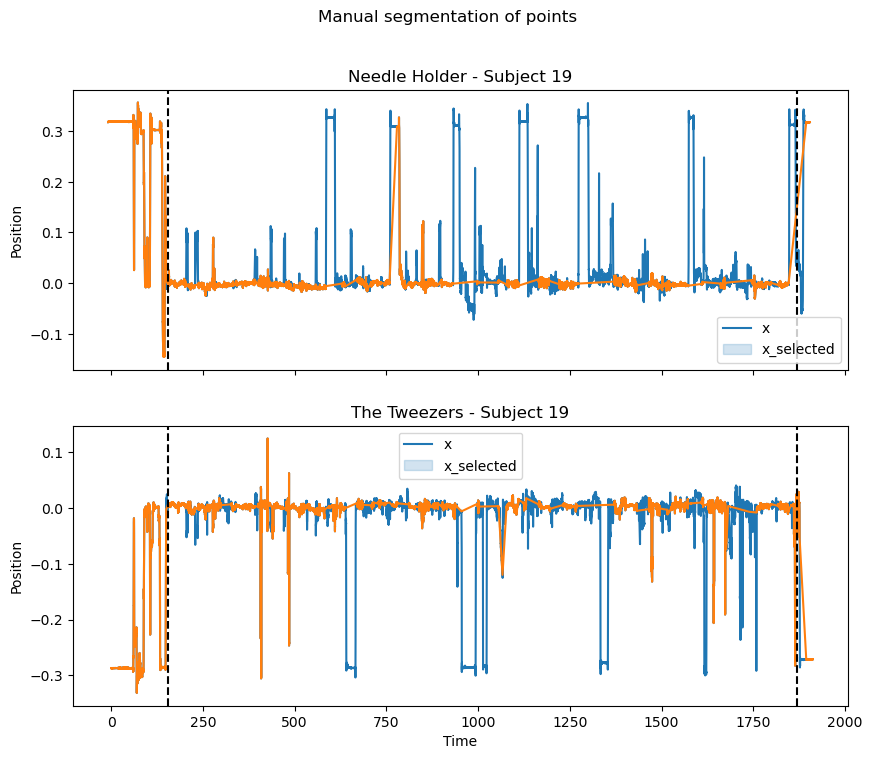

In [10]:
start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
sns.lineplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
#sns.scatterplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
#sns.scatterplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')

#ax1.axvline(x=1851, color='red', linestyle='--') #video
#ax1.axvline(x=1848.5, color='green', linestyle='--') #tracking = video +40
#ax1.set_xlim(1800, 1950)


ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title(f'Needle Holder - Subject {subject}')
ax1.legend(['x', 'x_selected'])

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
sns.lineplot(x=selected_tw_manual['Time (Seconds)'], y=selected_tw_manual['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')


ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.legend(['x', 'x_selected'])
ax2.set_title(f'The Tweezers - Subject {subject}')
plt.suptitle('Manual segmentation of points')
plt.show()

## DO IT FOR ALL SUBJECT ANNOTATED

In [11]:
delta_video_tracking = {'20': [13, 14, 15],
                        '27' : [-1.5, 0, 0],
                        '13' : [-15.5, -14, -13],
                        '10' : [5, 7, 0],
                        '16' : [40, 0, 0],
                        '19': [-3.5, -2.5, 0]}

In [ ]:
sub_manual = pd.read_csv('Annotations_final.csv', sep=';', decimal=',')
sub_manual['Start_event'] = sub_manual['Start_event'].round(3)
sub_manual['End_event'] = sub_manual['End_event'].round(3)
sub_manual = adjust_time_on_nbr_videos(sub_manual) #adjust time when there were several videos

#convert in s
sub_manual['Start_event_s'] = sub_manual['Start_event'].astype('str').apply(convert_to_seconds)
sub_manual['End_event_s'] = sub_manual['End_event'].astype('str').apply(convert_to_seconds)

sub_manual_nh = sub_manual[(sub_manual['Tool']=='NH') | (sub_manual['Tool']=='Both')]
sub_manual_tw = sub_manual[(sub_manual['Tool']=='TW') | (sub_manual['Tool']=='Both')]

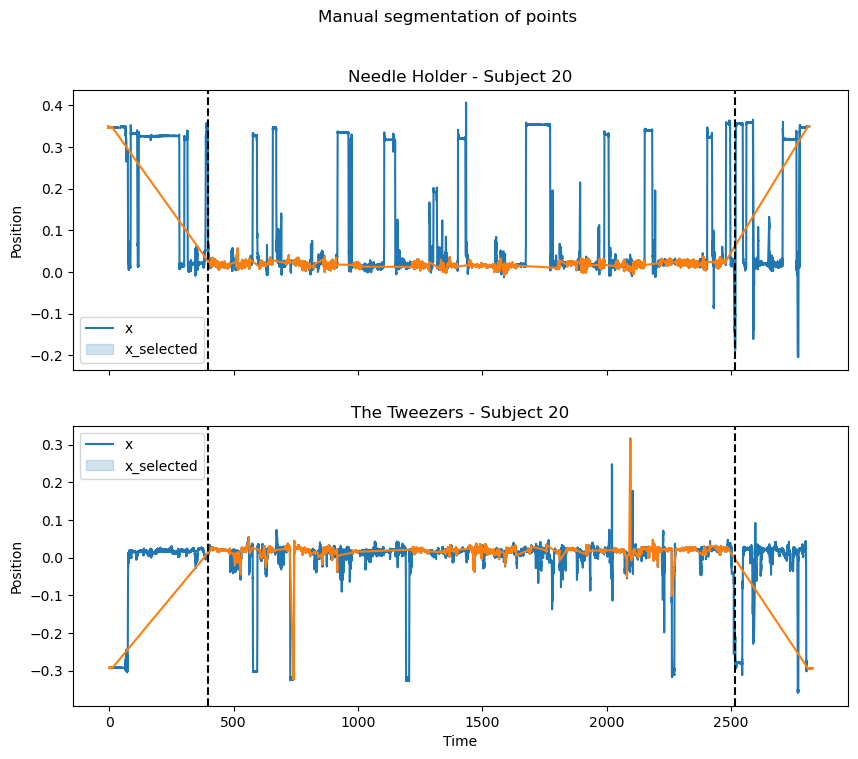

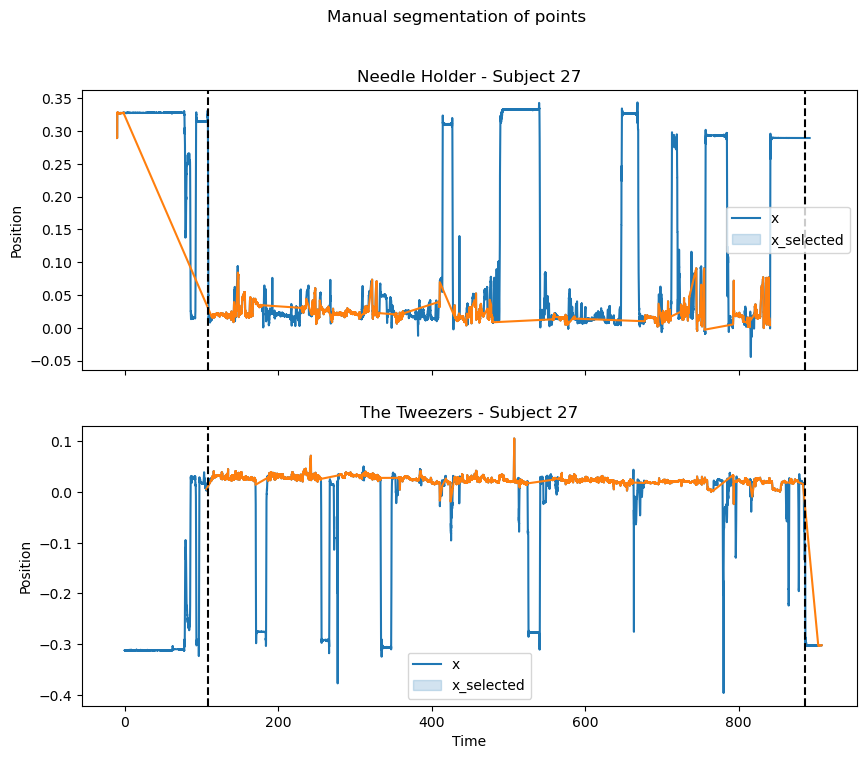

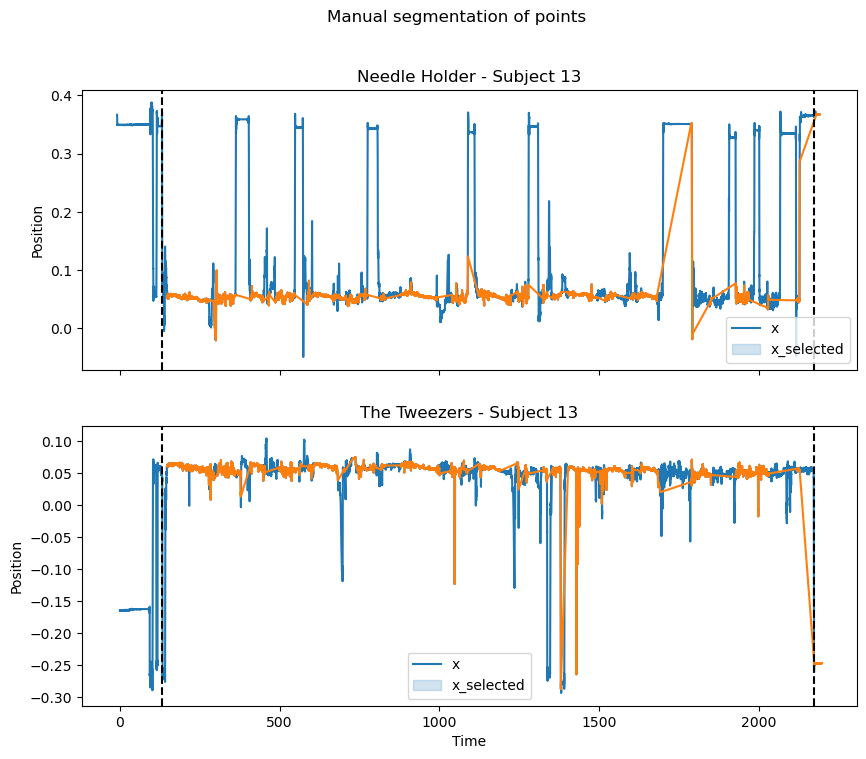

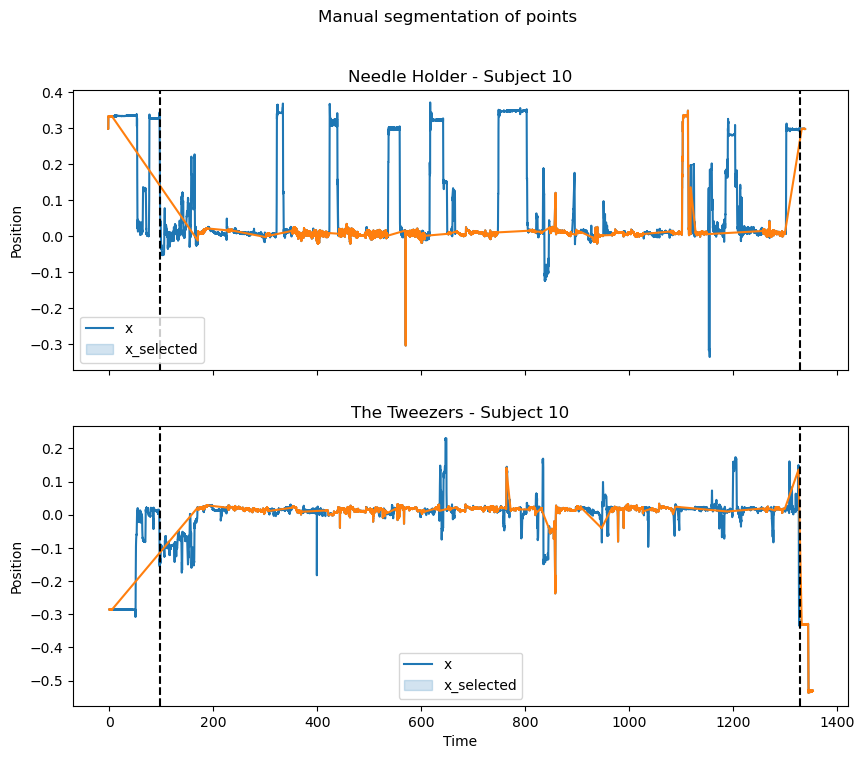

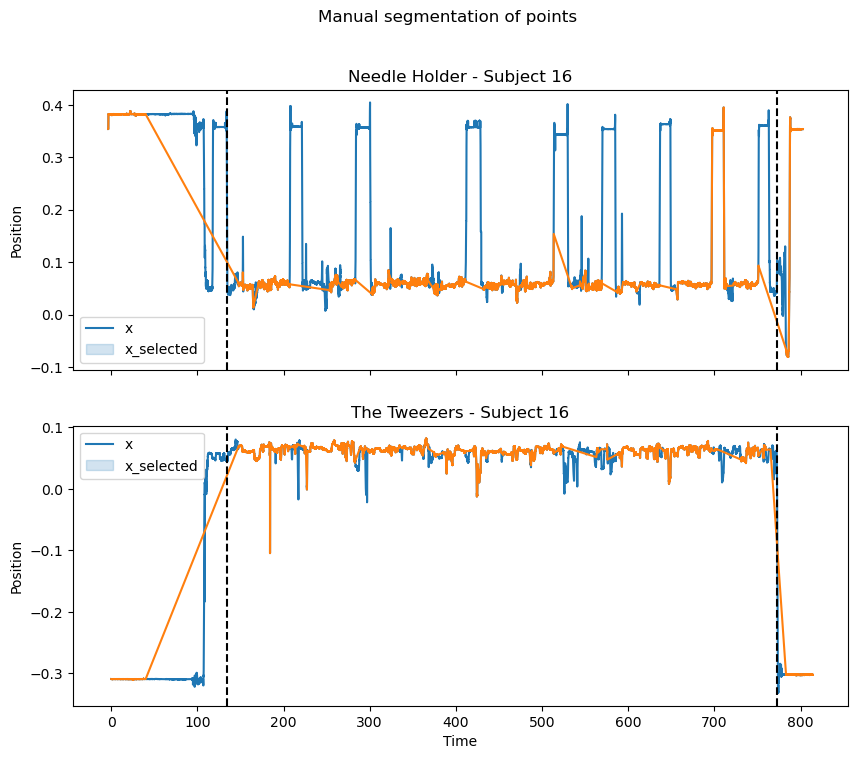

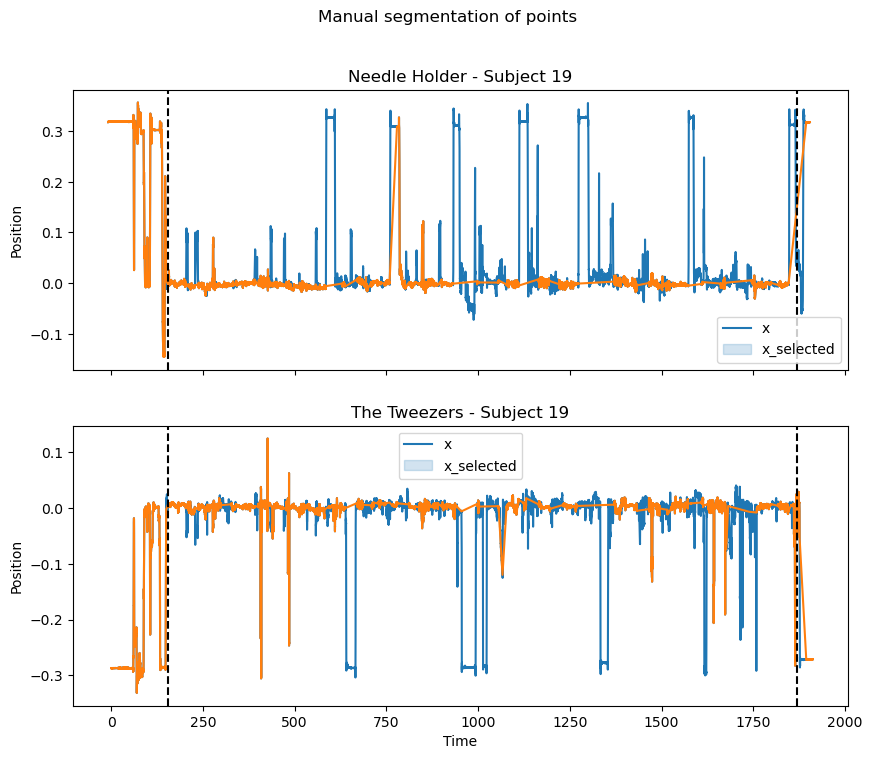

In [13]:
subjects = [20, 27, 13, 10, 16, 19]
i_ = [10, 11, 7, 6, 8, 1]

for index, subject in enumerate (subjects):
    i = i_[index]
    one_sub_nh = sub_manual_nh[sub_manual_nh['Subject']==subject]
    one_sub_tw = sub_manual_tw[sub_manual_tw['Subject']==subject]

    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

    delta = delta_video_tracking[str(subject)]
    selected_nh_manual = select_points_manually1(one_sub_nh, needle_holder_rec, delta_video_tracking=delta)
    selected_tw_manual = select_points_manually1(one_sub_tw, tweezers_rec, delta_video_tracking=delta)

    start_t_task = full_segments_time[i]['1'][0]
    end_t_task = full_segments_time[i]['8'][1]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
    sns.lineplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)

    ax1.axvline(x=start_t_task, color='black', linestyle='--')
    ax1.axvline(x=end_t_task, color='black', linestyle='--')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Needle Holder - Subject {subject}')
    ax1.legend(['x', 'x_selected'])

    sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
    sns.lineplot(x=selected_tw_manual['Time (Seconds)'], y=selected_tw_manual['X.1'], ax=ax2)
    ax2.axvline(x=start_t_task, color='black', linestyle='--')
    ax2.axvline(x=end_t_task, color='black', linestyle='--')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.legend(['x', 'x_selected'])
    ax2.set_title(f'The Tweezers - Subject {subject}')
    plt.suptitle('Manual segmentation of points')
    plt.show()


## PROBLEM WITH SUBJ 17!!!

In [142]:
subject = 17
i=9
one_sub_nh = sub_manual_nh[sub_manual_nh['Subject']==subject]
one_sub_tw = sub_manual_tw[sub_manual_tw['Subject']==subject]
one_sub_nh.head(5)

,Subject,Start_event,End_event,Tool,Event,Video_nbr,Start_event_s,End_event_s
135,17,0.000,2.580,Both,Task preparation,1,0.0,178.0
138,17,3.235,3.290,NH,Tool raised,1,203.5,209.0
140,17,3.290,3.350,NH,Pulling thread,1,209.0,215.0
141,17,3.350,3.380,NH,Tool raised,1,215.0,218.0
142,17,3.380,3.475,NH,Pulling thread,1,218.0,227.5


In [170]:
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

selected_nh_manual = select_points_manually(one_sub_nh, needle_holder_rec, delta_video_tracking=-106)
selected_tw_manual = select_points_manually(one_sub_tw, tweezers_rec, delta_video_tracking=-106)

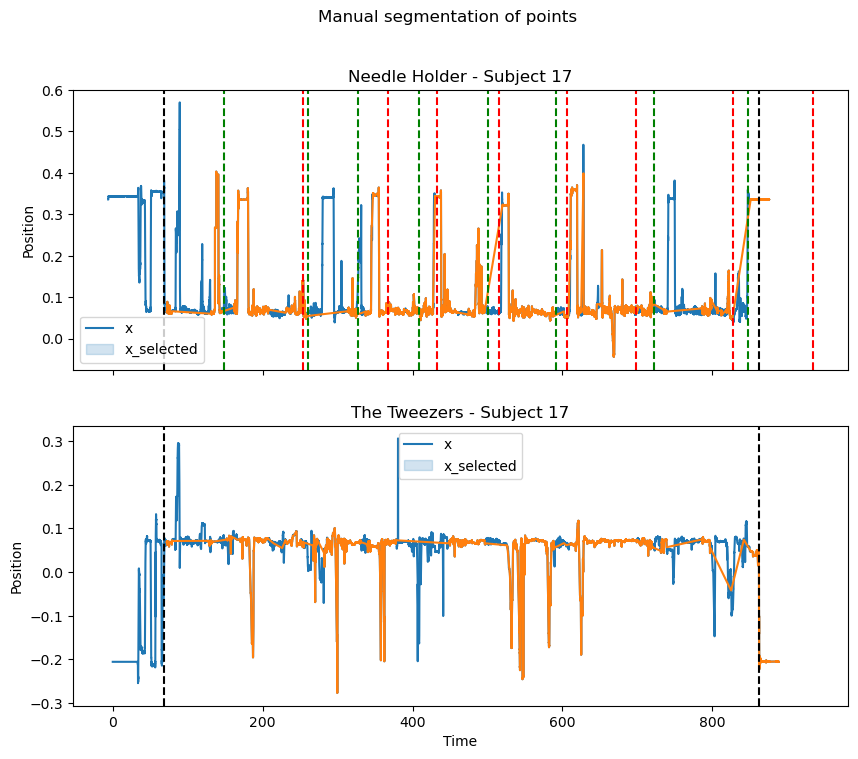

In [171]:
start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
sns.lineplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
#sns.scatterplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
#sns.scatterplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')

ax1.axvline(x=254, color='red', linestyle='--') #video
ax1.axvline(x=254-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=367, color='red', linestyle='--') #video
ax1.axvline(x=367-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=433, color='red', linestyle='--') #video
ax1.axvline(x=433-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=515, color='red', linestyle='--') #video
ax1.axvline(x=515-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=606, color='red', linestyle='--') #video
ax1.axvline(x=606-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=698, color='red', linestyle='--') #video
ax1.axvline(x=698-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=828, color='red', linestyle='--') #video
ax1.axvline(x=828-106, color='green', linestyle='--') #tracking = video +40
ax1.axvline(x=934, color='red', linestyle='--') #video
ax1.axvline(x=848, color='green', linestyle='--') #tracking = video +40
#ax1.set_xlim(750, 950)


ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title(f'Needle Holder - Subject {subject}')
ax1.legend(['x', 'x_selected'])

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
sns.lineplot(x=selected_tw_manual['Time (Seconds)'], y=selected_tw_manual['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')


ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.legend(['x', 'x_selected'])
ax2.set_title(f'The Tweezers - Subject {subject}')
plt.suptitle('Manual segmentation of points')
plt.show()